# Imports

In [4]:
import pyabf
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal


# Set Paths

In [5]:
# Define the project path and a list of 5 ABF file names
project_path = 'C:\\Users\\ikmor\\OneDrive\\Documents\\SNR AND OBR pilot study\\'

abf_files_set1 = [
    f'{project_path}PTX10 CNQX A3.abf',
    f'{project_path}DS5L4 ACCOM.abf',
    f'{project_path}DS5R2 ACCOM.abf',
    f'{project_path}DS4 ACCOM.abf'
]
abf_files_set2 = [
    f'{project_path}PTX10 CNQX APPLIED A3.abf',
    f'{project_path}DS5L4CNQX ACCOM.abf',
    f'{project_path}DS5R2 CNQX ACCOM.abf',
    f'{project_path}DS4CNQX ACCOM.abf']


c:\Users\ikmor\anaconda3\Lib\site-packages\scipy\signal\_spectral_py.py:600: UserWarning: nperseg = 20000 is greater than input length  = 18000, using nperseg = 18000
  freqs, _, Pxy = _spectral_helper(x, y, fs, window, nperseg, noverlap,


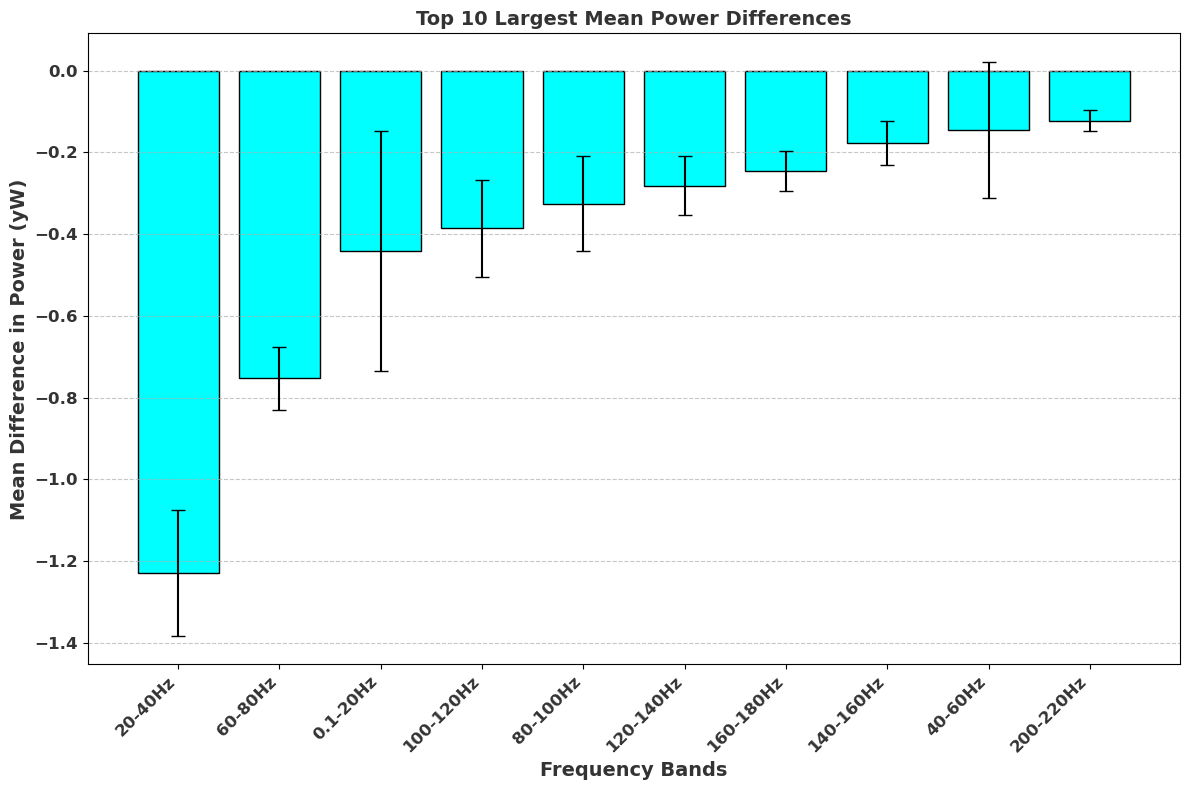


Top 10 Largest Mean Power Differences with Standard Errors:
1. 20-40Hz: Mean = -1.228071e+00 yW, SE = 1.543316e-01 yW
2. 60-80Hz: Mean = -7.525321e-01 yW, SE = 7.662701e-02 yW
3. 0.1-20Hz: Mean = -4.402742e-01 yW, SE = 2.938013e-01 yW
4. 100-120Hz: Mean = -3.857216e-01 yW, SE = 1.193490e-01 yW
5. 80-100Hz: Mean = -3.251548e-01 yW, SE = 1.170526e-01 yW
6. 120-140Hz: Mean = -2.816129e-01 yW, SE = 7.185536e-02 yW
7. 160-180Hz: Mean = -2.451661e-01 yW, SE = 4.864723e-02 yW
8. 140-160Hz: Mean = -1.772641e-01 yW, SE = 5.349520e-02 yW
9. 40-60Hz: Mean = -1.446586e-01 yW, SE = 1.659964e-01 yW
10. 200-220Hz: Mean = -1.218223e-01 yW, SE = 2.561662e-02 yW


In [6]:
# Input resistance for each file (in MegaOhms)
input_resistances_set1 = []
input_resistances_set2 = []

for file in abf_files_set1:
    resistance = float(input(f"Enter input resistance (MegaOhms) for {file}: "))
    input_resistances_set1.append(resistance * 1e6)  # Convert to Ohms

for file in abf_files_set2:
    resistance = float(input(f"Enter input resistance (MegaOhms) for {file}: "))
    input_resistances_set2.append(resistance * 1e6)  # Convert to Ohms

# Define new frequency bands from 0.1Hz to 8kHz in 20Hz increments
new_bands = [(0.1, 20)]
for i in range(20, 8000, 20):
    new_bands.append((i, i + 20))

def process_file(file_name, input_resistance):
    sweep_powers = [[] for _ in range(10)]  # 10 sweeps
    LJP = 13  # Liquid Junction Potential in mV

    abf = pyabf.ABF(file_name)
   
    for sweep in range(10):
        abf.setSweep(sweep, channel=0)
       
        start_time, end_time = 3.2, 4.1  # Time segment for analysis (in seconds)
        voltage = abf.sweepY - LJP  # Voltage in mV
        times = abf.sweepX  # Time in seconds
       
        start_index = np.argmin(np.abs(times - start_time))
        end_index = np.argmin(np.abs(times - end_time))

        segment_voltage = voltage[start_index:end_index]
        segment_voltage_V = segment_voltage * 1e-3  # Convert mV to V

        instantaneous_power = segment_voltage_V ** 2 / input_resistance

        fs = abf.dataRate  # Sampling frequency
        segment_length_ms = 50
        nperseg = int(fs * segment_length_ms / 1000)
        noverlap = nperseg // 2
        nperseg += nperseg % 2
        nfft = 320000

        f, Pxx = signal.welch(instantaneous_power, fs=fs, window='hann', nperseg=nperseg,
                              noverlap=noverlap, nfft=nfft, scaling='density')

        band_powers = []

        for band_start, band_end in new_bands:
            band_mask = (f >= band_start) & (f < band_end)
            band_power = np.trapz(Pxx[band_mask], f[band_mask])
            band_powers.append(band_power * (end_time - start_time) * 1e24)  # Convert to yoctoWatt

        sweep_powers[sweep] = band_powers

    return np.array(sweep_powers)

def process_file_set_with_new_bands(file_list, input_resistances):
    all_powers = []
    for file, resistance in zip(file_list, input_resistances):
        all_powers.append(process_file(file, resistance))
    return np.array(all_powers)

# Process both sets of files with new bands and calculate differences
all_powers_set1_new = process_file_set_with_new_bands(abf_files_set1, input_resistances_set1)
all_powers_set2_new = process_file_set_with_new_bands(abf_files_set2, input_resistances_set2)

avg_powers_set1_new = np.mean(all_powers_set1_new, axis=0)
avg_powers_set2_new = np.mean(all_powers_set2_new, axis=0)

power_differences_new = avg_powers_set2_new - avg_powers_set1_new

# Calculate mean power differences across all sweeps
mean_power_differences = np.mean(power_differences_new, axis=0)

# Calculate standard error for each band difference across sweeps
standard_errors_new = np.std(power_differences_new, axis=0, ddof=1) / np.sqrt(power_differences_new.shape[0])

# Find indices of top 10 largest mean power differences
top_10_indices = np.argsort(np.abs(mean_power_differences))[-10:][::-1]

# Create labels for the top 10 frequency bands
top_10_labels = [f"{new_bands[i][0]}-{new_bands[i][1]}Hz" for i in top_10_indices]

# Plot the top 10 largest mean power differences with error bars
plt.figure(figsize=(12, 8))
plt.bar(range(10), mean_power_differences[top_10_indices], yerr=standard_errors_new[top_10_indices],
        color='aqua', edgecolor='black', capsize=5)
plt.xlabel('Frequency Bands', fontsize=14, weight='bold', color='0.2')
plt.ylabel('Mean Difference in Power (yW)', fontsize=14, weight='bold', color='0.2')
plt.title('Top 10 Largest Mean Power Differences', fontsize=14, weight='bold', color='0.2')
plt.xticks(range(10), top_10_labels, rotation=45, ha='right', fontsize=12, weight='bold', color='0.2')
plt.yticks(fontsize=12, weight='bold', color='0.2')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Print the top 10 largest mean power differences with standard errors
print("\nTop 10 Largest Mean Power Differences with Standard Errors:")
for i, idx in enumerate(top_10_indices):
    print(f"{i+1}. {new_bands[idx][0]}-{new_bands[idx][1]}Hz: Mean = {mean_power_differences[idx]:.6e} yW, SE = {standard_errors_new[idx]:.6e} yW")
